# Data preprocessing

In [7]:
import polars as pl
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from helpers import *
from datetime import datetime, timedelta, date
from statsmodels.tsa.stattools import acf

Countries_indexes = ["EUSA", "EWC", "EWU", "EWG", "EWQ", "EWJ", "MCHI", "INDA", "EWA", "EWY", "EWW", "EWL", "EWT", "EWH", "EWS", "EWI", "EWP", "EWN", "EWD", "EWO", "EWK", "EDEN", "EFNL", "EIS", "EWZ"]

In [ ]:
assets_data = get_raw_data(range(2009,2013), Countries_indexes)

In [ ]:
bucketed_data = get_buckets(assets_data)

In [ ]:
clean_data = remove_outliers(bucketed_data)

Example of pre and post outlier removal for EWS

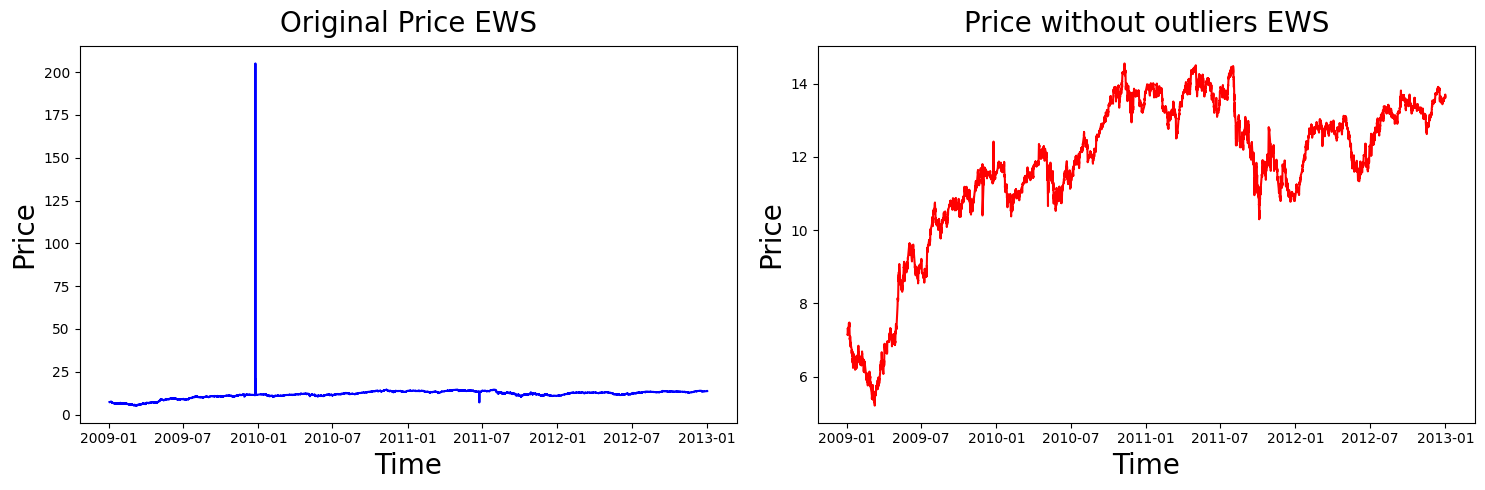

In [5]:
df, cleaned_df = bucketed_data["EWS"], clean_data["EWS"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the original data
ax1.plot(df['time-bucket'], df['weighted-avg-price'], color='b')
ax1.set_title(f'Original Price EWS', va='bottom', fontdict={'fontsize': 20})
ax1.set_xlabel('Time', fontdict={'fontsize': 20})
ax1.set_ylabel('Price', fontdict={'fontsize': 20})

# Plot the cleaned data
ax2.plot(cleaned_df['time-bucket'], cleaned_df['weighted-avg-price'], color='r')
ax2.set_title(f'Price without outliers EWS', va='bottom', fontdict={'fontsize': 20})
ax2.set_xlabel('Time', fontdict={'fontsize': 20})
ax2.set_ylabel('Price', fontdict={'fontsize': 20})

plt.tight_layout()
plt.show()

Now we can save the clean data

In [ ]:
save_folder = "Data/clean/"

for key in clean_data.keys():
    clean_data[key].write_parquet(f"{save_folder}{key}.parquet")

# Extreme mid-price jumps

In [3]:
asset_data = get_raw_data(years = range(2007, 2013, 1) ,asset_names = ["EWO"], print_log=False)

Text(0.5, 1.0, 'EWO ask price')

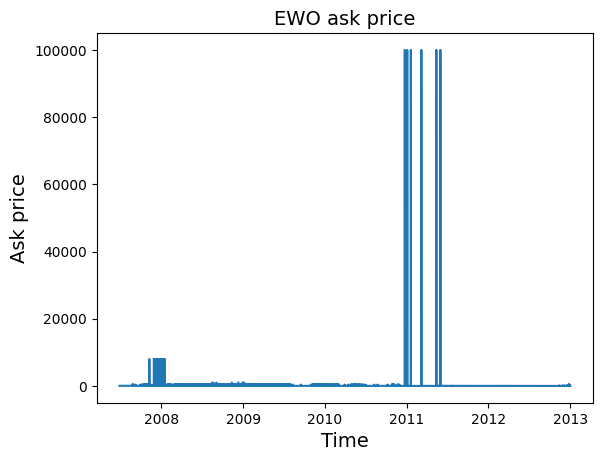

In [4]:
# plotting the ask price of EWO in time. We observe very extreme values in the ask price.
plt.plot(asset_data["EWO"]["datetime"],asset_data["EWO"]["ask-price"])
plt.xlabel("Time", fontdict={"size": 14})
plt.ylabel("Ask price", fontdict={"size": 14})
plt.title("EWO ask price", fontdict={"size": 14})

In [6]:
# Showing a sample of the jumps in the data
temp = asset_data["EWO"].filter(  
                                (pl.col("datetime").dt.date() == date(2007,8,24)) & (pl.col("datetime").dt.hour() == 13))
 
for row in temp.iter_rows(named=True):
    print(row)


{'bid-price': 36.76, 'bid-volume': 20, 'ask-price': 36.85, 'ask-volume': 1, 'datetime': datetime.datetime(2007, 8, 24, 13, 0, 0, 565000, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
{'bid-price': 36.75, 'bid-volume': 86, 'ask-price': 36.85, 'ask-volume': 1, 'datetime': datetime.datetime(2007, 8, 24, 13, 0, 0, 993000, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
{'bid-price': 36.75, 'bid-volume': 106, 'ask-price': 36.85, 'ask-volume': 1, 'datetime': datetime.datetime(2007, 8, 24, 13, 0, 1, 392000, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
{'bid-price': 36.75, 'bid-volume': 24, 'ask-price': 36.85, 'ask-volume': 1, 'datetime': datetime.datetime(2007, 8, 24, 13, 0, 6, 39999, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
{'bid-price': 36.75, 'bid-volume': 24, 'ask-price': 36.95, 'ask-volume': 1, 'datetime': datetime.datetime(2007, 8, 24, 13, 0, 25, 307999, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
{'bid-price': 36.77, 'bid-volume': 5, 'ask-price': 36.95, '

# Average Difference plot

Average differences computed in Average Difference.ipynb

In [6]:
import pandas as pd
average_diff_seconds = pd.read_csv("average_diffs_seconds.csv")

In [7]:
average_diff_seconds_clean = average_diff_seconds[~((average_diff_seconds['Ticker'] == "EDEN")| (average_diff_seconds['Ticker'] == "INDA")| (average_diff_seconds['Ticker'] == "EFNL"))]

We plotted also the average seconds without some tickers to make the plot more readable

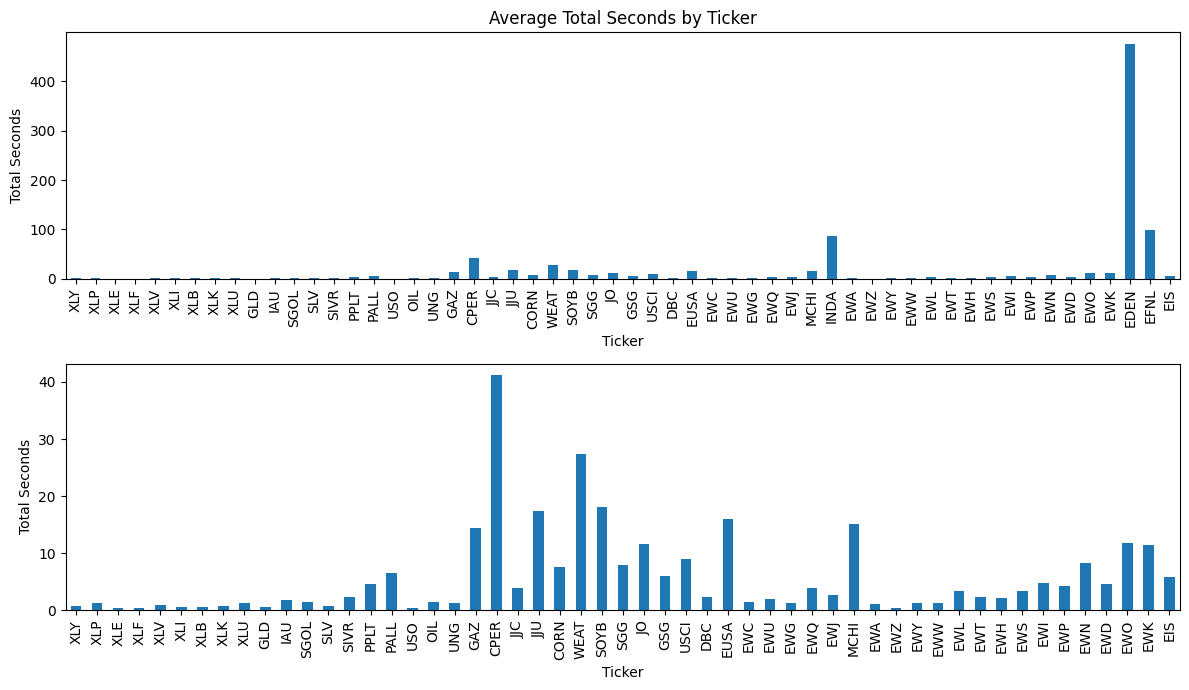

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(12, 7))

# First subplot: Average Total Seconds by Ticker
average_diff_seconds.plot(x='Ticker', y='Total_Seconds', kind='bar', ax=axs[0], legend=False)
axs[0].set_title('Average Total Seconds by Ticker')
axs[0].set_xlabel('Ticker')
axs[0].set_ylabel('Total Seconds')
axs[0].tick_params(axis='x', rotation=90)

# Second subplot: Price without outliers
average_diff_seconds_clean.plot(x='Ticker', y='Total_Seconds', kind='bar', ax=axs[1], legend=False)

axs[1].set_xlabel('Ticker')
axs[1].set_ylabel('Total Seconds')
axs[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Correlation analysis

In [8]:
file_path_ewu = "clean/EWU.parquet"
file_path_ewg = "clean/EWG.parquet"

df_ewu = pl.read_parquet(file_path_ewu)
df_ewg = pl.read_parquet(file_path_ewg)

filter_non_zero = True 

In [9]:
# Compute returns function in Polars
def compute_returns(df, price_col="weighted-avg-price", lag=1):
    return df.with_columns(
        (pl.col(price_col).diff(lag) / pl.col(price_col).shift(lag)).alias("return")
    ).drop_nulls(subset=["return"])

# Compute returns
df_ewu_ret = compute_returns(df_ewu)
df_ewg_ret = compute_returns(df_ewg)

# Extract return arrays
arr1 = df_ewu_ret["return"].to_numpy()
arr2 = df_ewg_ret["return"].to_numpy()

# Filter non-zero values
if filter_non_zero:
    non_zero_mask = ~((arr1 == 0) & (arr2 == 0))
    arr1 = arr1[non_zero_mask]
    arr2 = arr2[non_zero_mask]

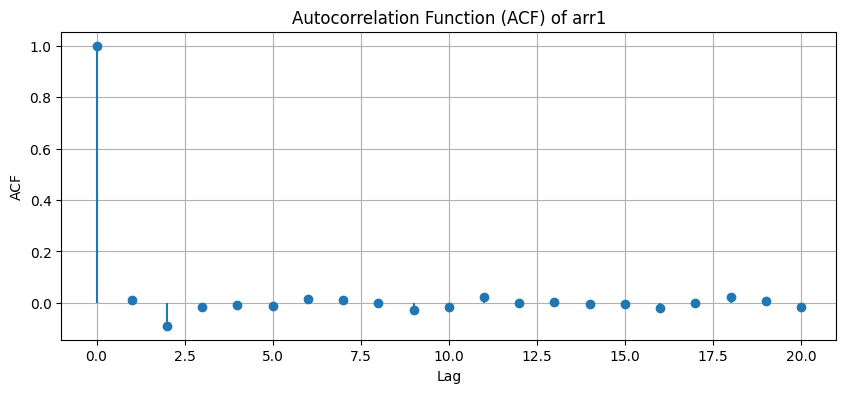

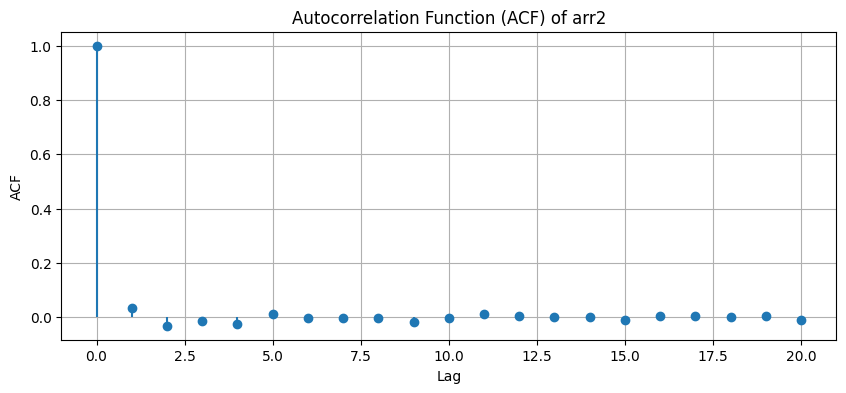

In [4]:

num_lags = 20 
# Compute the ACF for arr1
acf_arr1 = acf(arr1, nlags=num_lags, fft=True)

# Compute the ACF for arr2
acf_arr2 = acf(arr2, nlags=num_lags, fft=True)

# Plot the ACF for arr1
plt.figure(figsize=(10, 4))
plt.stem(range(len(acf_arr1)), acf_arr1, basefmt=" ")
plt.title("Autocorrelation Function (ACF) of arr1")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.grid(True)
plt.show()

# Plot the ACF for arr2
plt.figure(figsize=(10, 4))
plt.stem(range(len(acf_arr2)), acf_arr2, basefmt=" ")
plt.title("Autocorrelation Function (ACF) of arr2")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.grid(True)
plt.show()

In [10]:
def cross_correlation_lags(arr1, arr2, max_lag=100):
    """
    Computes correlation at all integer lags from -max_lag to +max_lag.
    
    Returns
    -------
    lags : np.ndarray of shape (2*max_lag+1,)
        The lag values (negative to positive).
    corrs : np.ndarray of shape (2*max_lag+1,)
        The correlation for each lag.
    """
    lags = np.arange(-max_lag, max_lag + 1)
    corrs = []

    for lag in lags:
        if lag < 0:
            # Example: lag = -5 => arr2 is 'ahead' of arr1 by 5 steps
            offset = -lag
            x1 = arr1[:len(arr1) - offset]
            x2 = arr2[offset:]
        elif lag > 0:
            # Example: lag = +5 => arr2 is 'behind' arr1 by 5 steps
            x1 = arr1[lag:]
            x2 = arr2[:len(arr2) - lag]
        else:
            # lag == 0 => no shift
            x1 = arr1
            x2 = arr2

        # Make sure we have enough points to correlate
        if len(x1) > 1 and len(x1) == len(x2):
            corr = np.corrcoef(x1, x2)[0, 1]
        else:
            corr = np.nan
        corrs.append(corr)

    return lags, np.array(corrs)


#### total correlation

In [19]:
lags, correlations = cross_correlation_lags(arr1, arr2, max_lag=0)
print(correlations)

[0.58783318]


#### lags correlation

In [11]:
lags, correlations = cross_correlation_lags(arr1, arr2, max_lag=20)

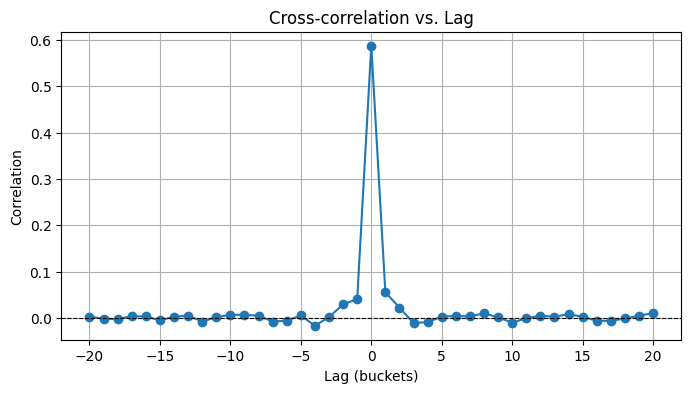

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(lags, correlations, marker='o')
plt.title("Cross-correlation vs. Lag")
plt.xlabel("Lag (buckets)")
plt.ylabel("Correlation")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(True)
plt.show()


## Rolling correlation

In [13]:
def rolling_cross_correlation(df1, df2, column1, column2, window_length, delta_step=5):
    """
    Compute rolling cross-correlation between two DataFrames.
    
    Parameters:
    - df1, df2: Polars DataFrames
    - column1, column2: Column names to correlate
    - window_length: Size of the rolling window
    - delta_step: Sliding window step size
    
    Returns:
    Polars DataFrame with correlation results
    """
    # Convert to NumPy for correlation computation
    arr1 = df1[column1].to_numpy()
    arr2 = df2[column2].to_numpy()

    # non_zero_mask = ~((arr1 == 0) & (arr2 == 0))

    # # Apply the mask to arr1 and arr2
    # arr1 = arr1[non_zero_mask]
    # arr2 = arr2[non_zero_mask]
    
    correlations = []
    window_starts = []
    
    # Slide window with specified delta step
    for start in range(0, len(arr1) - window_length + 1, delta_step):
        end = start + window_length
        window_start = start
        
        window1 = arr1[start:end]
        window2 = arr2[start:end]
        
        # Compute correlation for the current window
        correlation = np.corrcoef(window1, window2)[0, 1]
        
        correlations.append(correlation)
        window_starts.append(window_start)
    
    # Create Polars DataFrame with results
    result_df = pl.DataFrame({
        "window_start": window_starts,
        "correlation": correlations
    })
    
    return result_df

In [14]:
rolling_corr_df = rolling_cross_correlation(
    df_ewu_ret, df_ewg_ret, 
    column1="return", column2="return", 
    window_length=60, 
    delta_step=5,
)

print(rolling_corr_df)

/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/lucasalvador/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


shape: (797_734, 2)
┌──────────────┬─────────────┐
│ window_start ┆ correlation │
│ ---          ┆ ---         │
│ i64          ┆ f64         │
╞══════════════╪═════════════╡
│ 0            ┆ 0.136812    │
│ 5            ┆ 0.201624    │
│ 10           ┆ 0.136179    │
│ 15           ┆ 0.172598    │
│ 20           ┆ -0.013185   │
│ …            ┆ …           │
│ 3988645      ┆ 0.535755    │
│ 3988650      ┆ 0.539753    │
│ 3988655      ┆ 0.53369     │
│ 3988660      ┆ 0.507127    │
│ 3988665      ┆ 0.507127    │
└──────────────┴─────────────┘


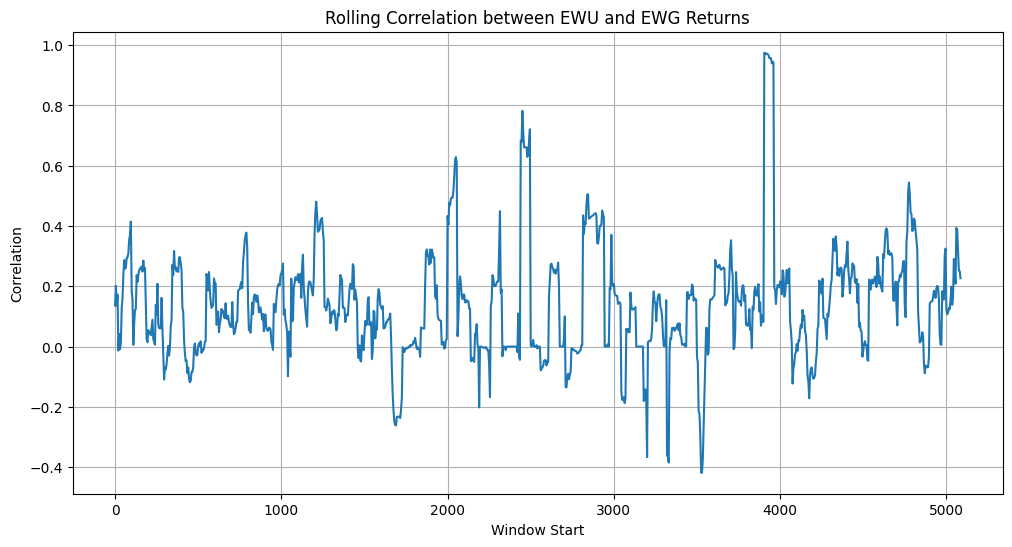

In [15]:
#Drop NANs and plot
rolling_corr_df = rolling_corr_df.fill_nan(None)   
rolling_corr_df = rolling_corr_df.drop_nulls()

first_obs = rolling_corr_df.head(1000)

plt.figure(figsize=(12, 6))
plt.plot(first_obs['window_start'], first_obs['correlation'])
plt.title('Rolling Correlation between EWU and EWG Returns')
plt.xlabel('Window Start')
plt.ylabel('Correlation')
plt.grid(True)


In [16]:
rolling_corr_df.mean()

window_start,correlation
f64,f64
1.9930e6,0.266677


# correlation analysis amir

In [5]:
asset_data = get_raw_data(years = range(2009, 2013, 1) ,asset_names = ["EWO", "EWG"], print_log=False)

bucketed_data = get_buckets(asset_data)

clean_data = remove_outliers(bucketed_data)

FileNotFoundError: [Errno 2] No such file or directory: 'Data/ETFs/ETFs-2009.tar'

In [9]:
def calculate_correlation(df1, df2, lag=1):
    # Calculate returns for df1 and df2
    df1 = df1.with_columns(
        (df1["weighted-avg-price"] / df1["weighted-avg-price"].shift(lag) - 1).alias("return_1")
    )
    df2 = df2.with_columns(
        (df2["weighted-avg-price"] / df2["weighted-avg-price"].shift(lag) - 1).alias("return_2")
    )

    # Drop nulls and NaNs from return calculations
    df1 = df1.drop_nulls(["return_1"])
    df2 = df2.drop_nulls(["return_2"])
    
    # Remove the last return row of each day for df1
    df1 = (
        df1.with_columns(pl.col("time-bucket").dt.truncate("1d").alias("date"))  # Extract date
        .sort(["date", "time-bucket"])  # Sort by date and time-bucket
        .group_by("date", maintain_order=True)
        .map_groups(lambda df: df.head(-1))  # Exclude last row per group
    )
    # Remove the last return row of each day for df2
    df2 = (
        df2.with_columns(pl.col("time-bucket").dt.truncate("1d").alias("date"))
        .sort(["date", "time-bucket"])
        .group_by("date", maintain_order=True)
        .map_groups(lambda df: df.head(-1))
    )

    # Perform an inner join on "time-bucket"
    result = df1.join(df2, on="time-bucket", how="inner")

    
    # Calculate and return the correlation
    correlation = result.select(pl.corr("return_1", "return_2"))
    return correlation

# Example usage
calculate_correlation(clean_data["EWO"], clean_data["EWG"], lag=1)


return_1
f64
0.483749


## Epps Effect

In [ ]:
def plot_epps_effect(data1, data2):
    delta_t = np.arange(500, 10500,  1000)
    # drop nan values
    correlations = {}
    for dt in tqdm.tqdm(delta_t):
        data1_temp = get_buckets(data1, deltat=dt, only_trading_hours=True)
        data2_temp = get_buckets(data2, deltat=dt, only_trading_hours=True)
        print(len(data1_temp), len(data2_temp))
        print(data1_temp.schema)
        print(data2_temp.schema)
        data1_temp = remove_outliers(data1_temp)
        data2_temp = remove_outliers(data2_temp)
        print(len(data1_temp), len(data2_temp))
        correlations[dt] = calculate_correlation(data1_temp, data2_temp, lag=1)
    plt.scatter(correlations.keys(), correlations.values())
    # plt.xscale('log')
    plt.xlabel('Time interval (seconds)')
    plt.ylabel('Correlation')
    plt.title('Epps effect')
    
plot_epps_effect(asset_data["EWG"], asset_data["EWO"])

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Amirmahdi\AppData\Local\Temp\ipykernel_13576\695872149.py:16: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  (result["time-bucket"].map_elements(lambda x: datetime.utcfromtimestamp(x))),
  0%|          | 0/10 [00:38<?, ?it/s]

47329 47329
Schema([('weighted-avg-price', Float64), ('time-bucket', Datetime(time_unit='us', time_zone='America/New_York'))])
Schema([('weighted-avg-price', Float64), ('time-bucket', Datetime(time_unit='us', time_zone='America/New_York'))])
0 37330


NameError: name 'calculate_correlation' is not defined

##